# Sales Ratio Study - A Walk Through Mercer County Property Data

This project uses publicly-available property sale data for the state of New Jersey and methodology published by the Minnesota Department of Revenue to recreate a sales ratio study in R.

Sales ratio studies check that properties are assessed correctly, that particular townships and counties are not biased in their assessments, and that expensive properties are not chronically over- or under- assessed compared to less expensive ones. 

All this determines how much of the tax burden is carried by you, and how much is carried by your neighbors. If your property is over-valued compared to your neighbors’, you can end up paying more than your fair share of taxes. If _every_ property in the township is overvalued, the township taxes are portioned fairly but the township pays a disproportionate share of county and state taxes.

Sales ratio studies are performed by the state to make sure individuals and townships are carrying their share of the tax burden, and that properties are being assessed accurately.  

This is what they do.

## What is a Sales Ratio?

A sales ratio compares the assessed value of a property to its sale price. 

$$Sales Ratio = \left( \frac{Assessed Value}{Sale Price} \right)  $$

A sales ratio of 1/2 means the property was valued at half the price paid for it, and a sales ratio of 2 means the property was valued at twice the price paid for it. Generally, a sales ratio greater than 1 suggests a property was over-valued, and a sales ratio less than 1 suggests the property was under-valued.


## Sources

For this project, I took property sale records for every county in New Jersey from this Monmouth County site:

http://tax1.co.monmouth.nj.us/cgi-bin/prc6.cgi?menu=index&ms_user=glou&district=0801&mode=11

And I recreated the sales ratio study used by the Minnesota Department of Revenue, as described here:

https://www.revenue.state.mn.us/sales-ratio-studies

To interpret the column names, I used:

https://www.state.nj.us/treasury/taxation/pdf/lpt/SR1A_FileLayout_Description.pdf 

and for U-N-Code interpretation:

https://www.state.nj.us/treasury/taxation/pdf/lpt/guidelines33.pdf

I also use these R packages:

In [2]:
library(readr)
library(tidyverse)
library(lubridate)
library(modelr)
library(MASS)
library(ggplot2)

## Getting the Data

You can download the raw data in zip files from the Monmouth county website. There are some messy extra columns that confused my parser, and you may notice a data entry error that swapped the values for 'Total Assessment' and 'Building Assessment' in some rows. I wrote a script called tidy_county_datasets, available on my GitHub, to clean all that up and save it to the folder tidy_county. The scripts and folders there cover every county except Atlantic, but here I'm just walking through Mercer County to show the steps involved.

I load the tidied data:

In [12]:
propSales <- read_csv(file.path("~", "Mercer.csv"), show_col_types = FALSE)
c("These are the columns of the tidied dataset:")
colnames(propSales)

[1] "These are the columns of the tidied dataset:"

[1] "Municipality"    "Property Class"  "Total Assmnt"    "Land Assmnt"    
[5] "Building Assmnt" "Deed Date"       "Sale Price"      "NU Code"

Not every sale in the dataset represents the true value of the property. Sometimes people sell their property to family at a very low rate, or they are forced to sell because of financial trouble. These sales are marked with a 'NU Code' for "Not Usable". I'll filter these out, along with sales from any dates outside the range of interest: January 1, 2019 to September 30, 2020.

A couple of notes: when a government performs this study, there's a lot of pre-processing and double-checking involved that we can't re-create here. Special terms of sale are taken into account, improvements to the property are marked, and outlier sales ratios are automatically reviewed. Even having filtered sales with NU codes, you will often find properties sold for a dollar, or a hundred dollars. The county would flag these as outliers and send someone to investigate, but I will assume any sale for less than $1000 is a non-usable sale that has been incorrectly marked as usable, and filter it out.

Finally, only some of the available columns will be useful for this project. I'll select those and rename them here to save a little typing later on.

In [13]:
propSales <- propSales %>%
  filter(is.na(`NU Code`),             # Filter out non-usable sales
         `Deed Date` >= ymd(20190101), # Filter for the correct dates
         `Deed Date` <= ymd(20200930),
         `Sale Price` > 1000) %>%      # Filter out suspiciously low prices
  # select the interesting columns and rename them:
  dplyr::select(Municipality, `Property Class`, `Total Assmnt`, `Deed Date`, `Sale Price`) %>%
  rename(twp = Municipality, class = `Property Class`, assmnt = `Total Assmnt`, 
         date = `Deed Date`, price = `Sale Price`) %>%
  mutate(assmnt = as.integer(assmnt))

Now let's explore some of the data. Here I will plot the assessment on the y-axis against the sale price on the x-axis, with different colors representing the different property classes. A perfect correlation will fall on the line with slope 1. Points that fall above the diagonal may have been over-assessed, and points falling below it may have been under-assessed.

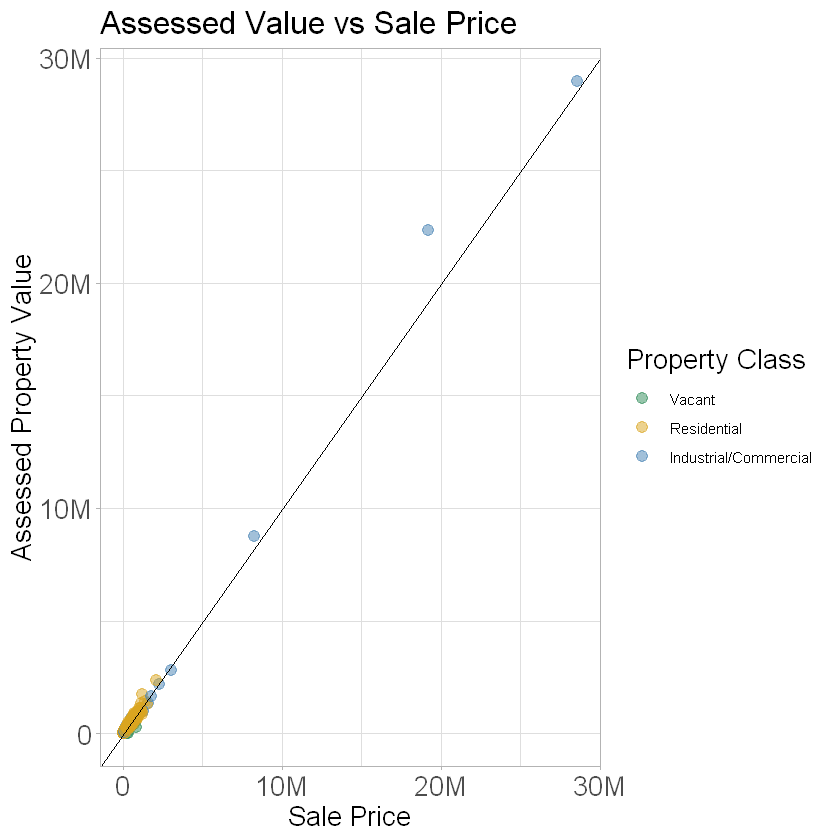

In [27]:
ggplot(propSales, aes(x=price, y = assmnt, color = factor(class))) + 
  geom_point(size = 3, alpha=1/2) + 
  theme_light() +
  labs(y = "Assessed Property Value",
       x = "Sale Price",
       title = "Assessed Value vs Sale Price",
       color = "Property Class") +
  scale_x_continuous(breaks=c(0, 10000000, 20000000, 30000000), labels = c(0, "10M", "20M", "30M")) +
  scale_y_continuous(breaks=c(0, 10000000, 20000000, 30000000), labels = c(0, "10M", "20M", "30M")) +
  scale_color_discrete(labels = c("Vacant", "Residential", "Industrial/Commercial"),
                      type = c("seagreen", "goldenrod", "steelblue")) +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16)) +
  geom_abline(intercept = 0, slope = 1)

Whoa, there are some expensive properties in the top right! They are all in property class 4, "commercial, industrial, and apartment buildings" (blue). Property sales in Mercer County are dominated by class 2, "residential property" (orange), but there is also a smattering of class 1: "vacant land sales" (green).

Let's log-transform the plot to get a better look at the lower left-hand corner:

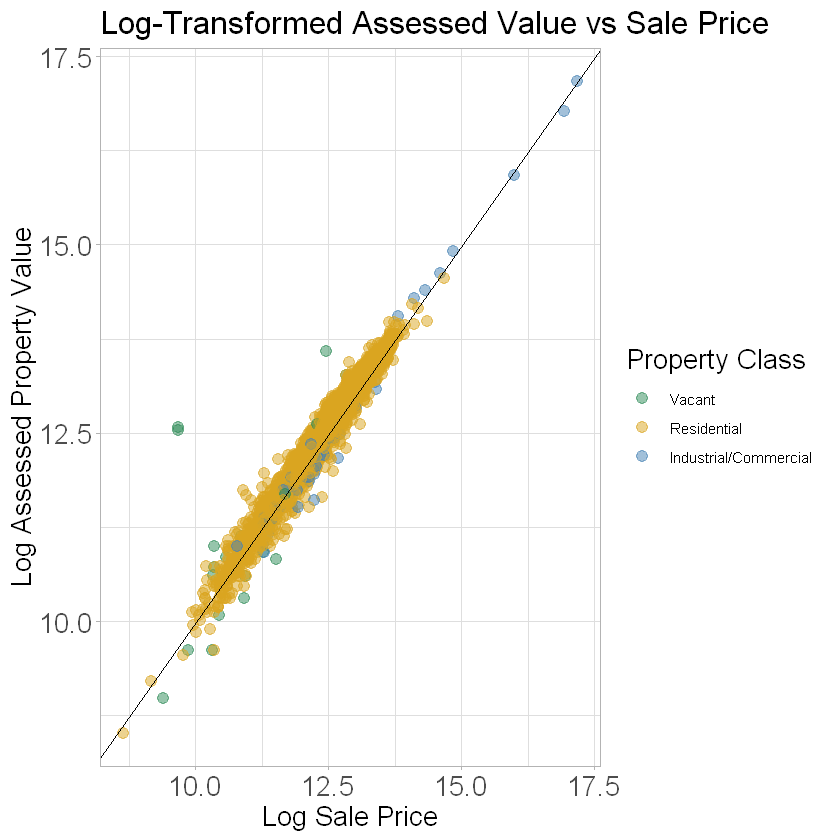

In [29]:
ggplot(propSales, aes(x=log(assmnt), y = log(price), color = factor(class))) + 
  geom_point(size = 3, alpha = 1/2) + 
  theme_light() +
  labs(y = "Log Assessed Property Value",
       x = "Log Sale Price",
       title = "Log-Transformed Assessed Value vs Sale Price",
       color = "Property Class") +
  scale_color_discrete(labels = c("Vacant", "Residential", "Industrial/Commercial"),
                      type = c("seagreen", "goldenrod", "steelblue")) +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16))+
  geom_abline(intercept = 0, slope = 1)

Here is the log-transformed plot of assessment against price. A few very expensive commercial/industrial properties may skew the distribution of sale prices, but the vast majority, 3611 of the 3737 properties, are residential.

House prices also skew to the right. Here is a histogram of property prices in Trenton, and another histogram for Hopewell:

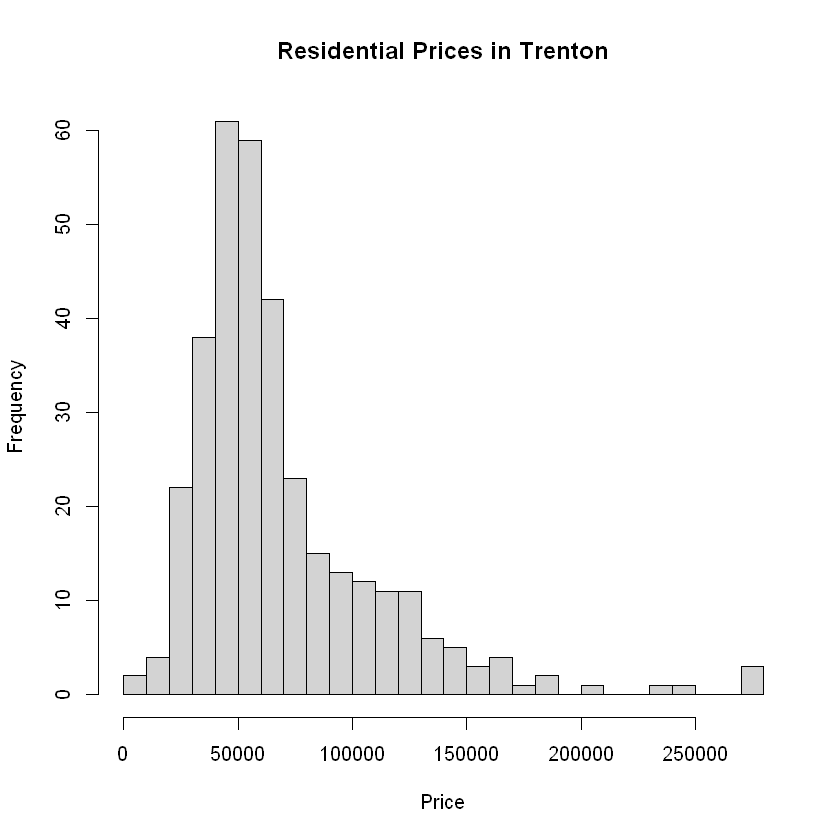

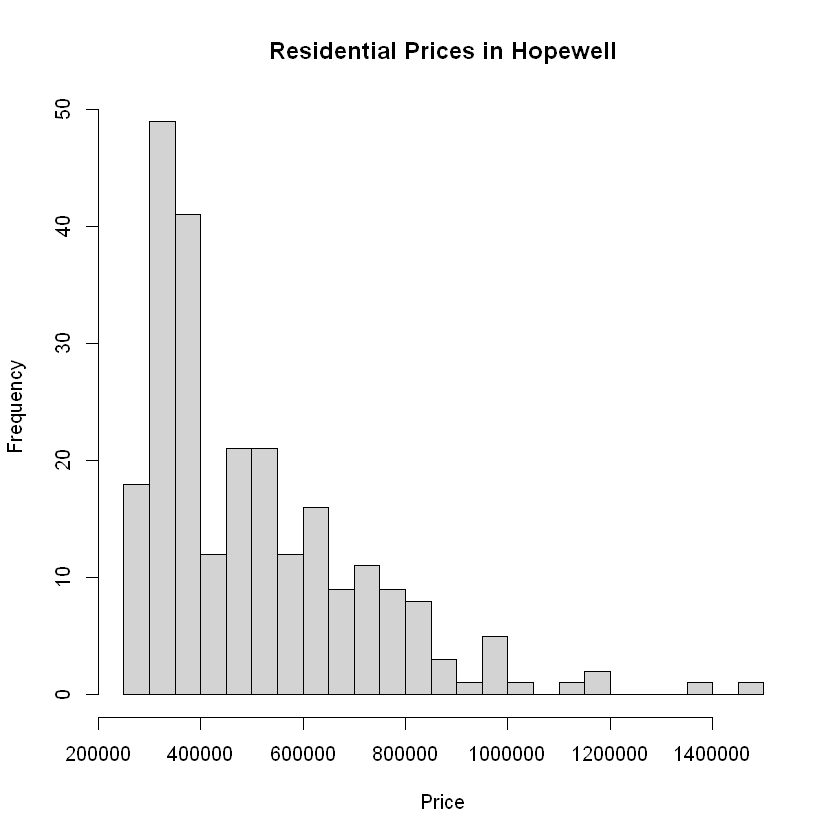

In [33]:
ggplot(propSales %>% filter(class == 2, twp == 1111),
       aes(x = price)) +
  theme_light() +
  ylab("Property Count") +
  xlab("Price") +
  ggtitle("Residential Property Prices in Trenton") +
  theme(title = element_text(size=16), 
        axis.title = element_text(size=16), 
        axis.text = element_text(size=14))+
  scale_x_continuous(breaks = c(0, 50000, 100000, 150000, 200000, 250000),
                     labels = c("$0", "$50,000", "$100,000", "$150,000", "$200,000", "$250,000")) +
  geom_histogram(bins = 20, fill = "#116778")


ggplot(propSales %>% filter(class == 2, twp == 1111),
       aes(x = price)) +
  theme_light() +
  ylab("Property Count") +
  xlab("Price") +
  ggtitle("Residential Property Prices in Trenton") +
  theme(title = element_text(size=16), 
        axis.title = element_text(size=16), 
        axis.text = element_text(size=14))+
  scale_x_continuous(breaks = c(250000, 500000, 750000, 1000000, 1250000),
                     labels = c("$250,000", "$500,000", "$750,000", "$1,000,000", "$1,250,000")) +
  geom_histogram(bins = 20, fill = "#116778")

There are analyses in this study that make a skew like this very undesirable. One reason to use the sales ratio instead of sale price in analyses is that the ratios normalize the skew. Check it out, for the same townships, sales ratios are distributed pretty normally:

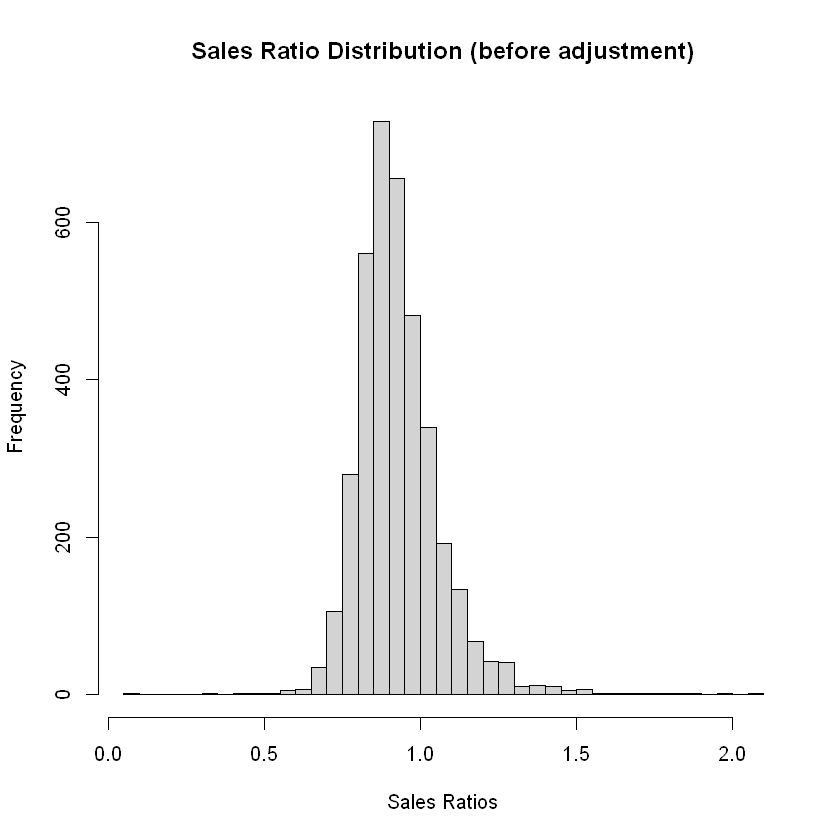

In [36]:
# Create naive sales ratio = assessment/price with which to identify outliers:
propSales <- propSales %>%
  mutate(naiveSR = assmnt / price) 

ggplot(propSales, aes(x=naiveSR)) +
  theme_light() +
  theme(title = element_text(size=16), 
        axis.title = element_text(size=16), 
        axis.text = element_text(size=14))+
  geom_histogram(bins = 40, fill = "#116778", color = "grey75") +
  ggtitle("Sales Ratio Distribution (Before Adjustment)") +
  ylab("Frequency") +
  xlab("Sales Ratios")

Because the sales ratios are roughly normally distributed, we can use a simple method to identify outliers with the inter-quartile range.


## Identifying Outliers

To find outliers I'll want to compare each property to similar ones nearby. Minnesota groups properties by location, property type, and whether there is a water feature on the property. I don't have any information on water features, but I'm guessing they affect fewer properties in New Jersey than in the 'Land of 10,000 Lakes', so we should be alright just grouping properties together by property class and township. Now I can whip up some summary statistics about the sales ratios in each group: 

- the 25th and 75th quantiles mark the smallest and largest sales ratios in the middle half of each group 

- the inter-quartile range (IQR) is the distance between those points, the size of the middle half

- the number of sales in each group (N)

I'll also assign each group an index now, so I can easily re-group them later.

In [37]:
propSales <- propSales %>%
  # Group by township, property type
  group_by(twp, class) %>%
  nest() %>%
  #  sapply takes each element of propSales$data and performs a summary stat function on it
  mutate(Q1 = sapply(data, function (x) quantile(x$naiveSR, probs = 0.25)),
         Q3 = sapply(data, function (x) quantile(x$naiveSR, probs = 0.75)),
         IQR = (Q3 - Q1),
         N = sapply(data, nrow)
    )
propSales$nestIndex <- 1:nrow(propSales)
 

There are many rules of thumb for identifying outliers. One is to count any observation more than 2 or 3 standard deviations from the average as an outlier.

Another method, the one used by the Minnesota Department of Revenue, is to find the inter-quartile range (IQR) and use it as a yardstick. Any point more than 1.5x the IQR from the upper or lower edge of the IQR is an outlier. 

Here I un-group the data so we can see every sale. I'll make a new column called "outlier" and fill in TRUE if the sales ratio is too far away from its group's center:

In [38]:
propSales <- propSales %>%
  unnest(cols = c(data)) %>%
  mutate (outlier = naiveSR < (Q1 - 1.5*IQR) | naiveSR > (Q3 + 1.5*IQR))
paste("There are ", sum(propSales$outlier), " outliers in the Mercer County data", sep = "")

[1] "There are 152 outliers in the Mercer County data"

The edge of outlierhood:

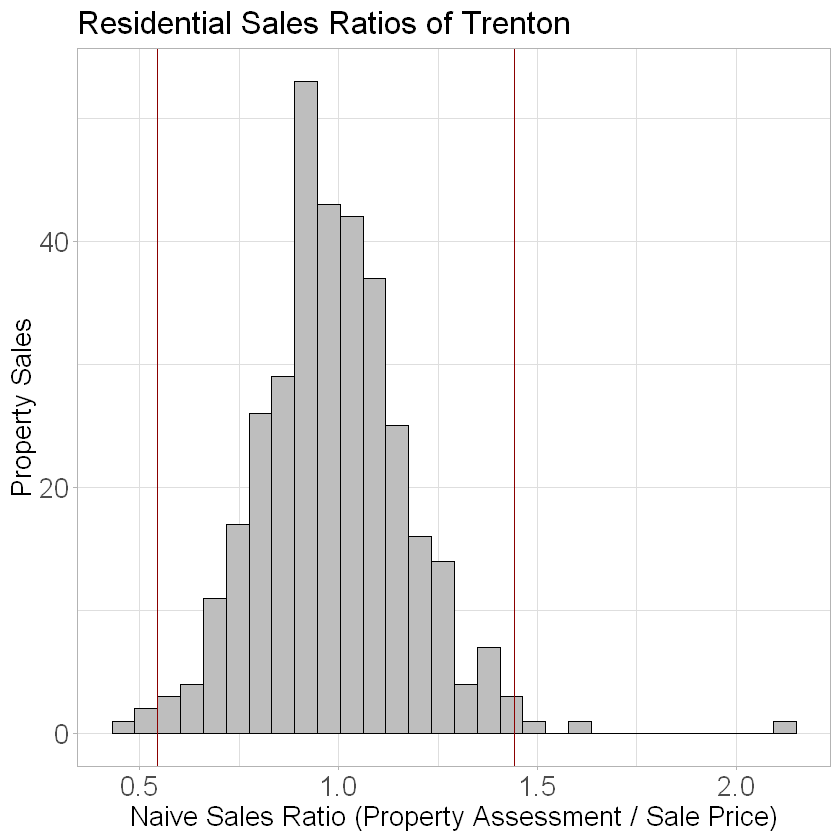

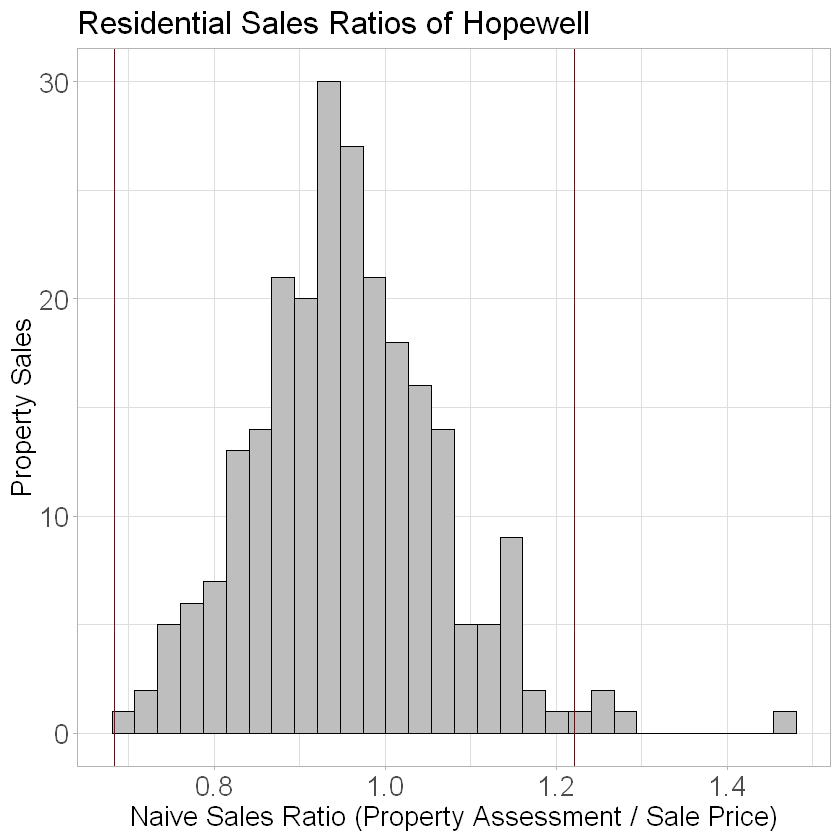

In [39]:
ggplot(data = propSales %>% filter(twp==1111, class == 2), aes(x=naiveSR)) + 
  theme_light() +
  geom_histogram(bins = 30, fill = "#116778") + 
  labs(x = expression(paste("Naive Sales Ratio: ", bgroup("(", over(`Property Assessment`, `Sale Price`), ")"))),
       y = "Frequency",
       title = "Residential Sales Ratios in Trenton") +
  theme(title = element_text(size=16), 
        axis.title = element_text(size=16), 
        axis.text = element_text(size=16)) +
  geom_vline(xintercept = .8806 - (1.5*.2248), color = "darkred", size = 2, alpha = 1/2) + #Trenton's Q1 - 1.5*IQR
  geom_vline(xintercept = 1.105 + (1.5*.2248), color="darkred", size = 2, alpha = 1/2) +   #Trenton's Q3 + 1.5*IQR
  geom_vline(xintercept = .9928, color="grey75", size = 1, alpha = 1/2)

ggplot(data = propSales %>% filter(twp==1106, class == 2), aes(x=naiveSR)) + 
  theme_light() +
  geom_histogram(bins = 30, fill = "#116778") + 
  labs(x = expression(paste("Naive Sales Ratio: ", bgroup("(", over(`Property Assessment`, `Sale Price`), ")"))),
       y = "Frequency",
       title = "Residential Sales Ratios in Hopewell") +
  theme(title = element_text(size=16), 
        axis.title = element_text(size=16), 
        axis.text = element_text(size=16)) +
  geom_vline(xintercept = .8849 - (1.5*.1345), 
             color = "darkred", size= 2, alpha = 1/2) +   # Hopewell's Q1 - 1.5*IQR
  geom_vline(xintercept = 1.0195 + (1.5*.1345), 
             color="darkred", size= 2, alpha = 1/2) +    # Hopewell's Q3 + 1.5*IQR
  geom_vline(xintercept = .9522, color="grey75", size = 1, alpha = 1/2)


I'll show the first plot again, assessed value vs sale price, with outliers highlighted:

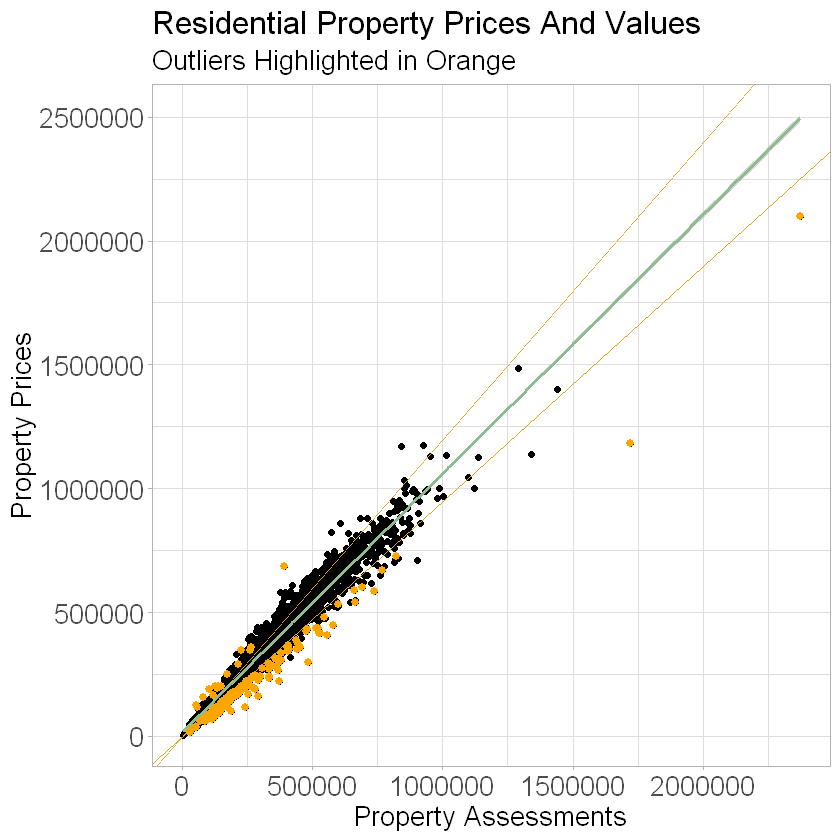

In [48]:
resid <- propSales %>% filter(class == 2)
ggplot(resid, aes(x=assmnt, y = price)) + 
  theme_light() +
  labs(title="Residential Property Prices And Values",
       subtitle="Outliers Highlighted in Orange",
       y="Property Prices",
       x="Property Assessments")+
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16))+
  geom_point() + 
  geom_point(data = filter(resid, outlier == TRUE), colour = "orange", size = 2) +
  geom_abline(slope = 1.2, intercept = 0, color = "darkgoldenrod") +
  geom_abline(slope = .95, intercept = 0, color = "darkgoldenrod") +
  geom_smooth(method = "lm", formula = y~x, color="darkseagreen")

Here are the sales ratios with outliers highlighted in orange. The two thin lines on either side of the trend line show what a 15% deviation from the trend looks like as property prices increase.

When prices and assessments are low, a small absolute change has a big effect on the sales ratio. When prices and assessments are higher, changes in the price or assessment don't have as big an effect. The result is this "beam" shape.

There is some variation. Since properties were grouped by type before outliers were identified, a sales ratio can be marked as an outlier in one group where it might not have been marked as an outlier in another group.

Next I will want to look at the data points that aren't outliers. I'll make a new table with outliers filtered out and call it "inliers".

In [49]:
inliers <- propSales %>% filter(outlier == FALSE)  

Done!

## Calculating Market Trends

The Minnesota Dept of Revenue assumes that assessments are generally uniform, that is, they don't trend up or down over the course of the year. But it does acknowledge that property prices can vary significantly over the year due to the real estate market. The next step, then, is to identify market trends since the study began, and use them to predict what the price would have been if every house had been sold on the first day of the study. That will give an apples-to-apples comparison of prices.

The first step is to make a note of the month of the study in which each property sold. Then bundle them back into their groups and filter for all the groups with at least 30 sales. These are the groups with enough data to actually show a pattern:

In [50]:
inliers <- inliers %>%
  mutate(studyMonth = ifelse(year(date) == 2019, month(date), month(date) + 12)) %>%
  # Only use groups with >= 30 inliers
  group_by(nestIndex, N) %>%
  nest() %>%
  filter (N >= 30)

This is the function that will calculate a linear trend line: 

$$LN\left(\frac{price}{assessment}\right) = \beta_{0} + \beta_{1} Study Month + \epsilon$$

In [51]:
market_trend_func <- function(df){
  lm(log(price / assmnt) ~ studyMonth, data = df) 
  }

Instead of sales ratios, I'm plotting the natural log of the inverse sales ratio $LN(\frac{price}{assessment})$. The only difference between this and the regular sales ratio is that it makes the graph easier to interpret: this way, the trend line will go up if prices go up, and the slope will be the percent change by month.

Here is a group in our "inliers" data table, sales of residential properties in Ewing:

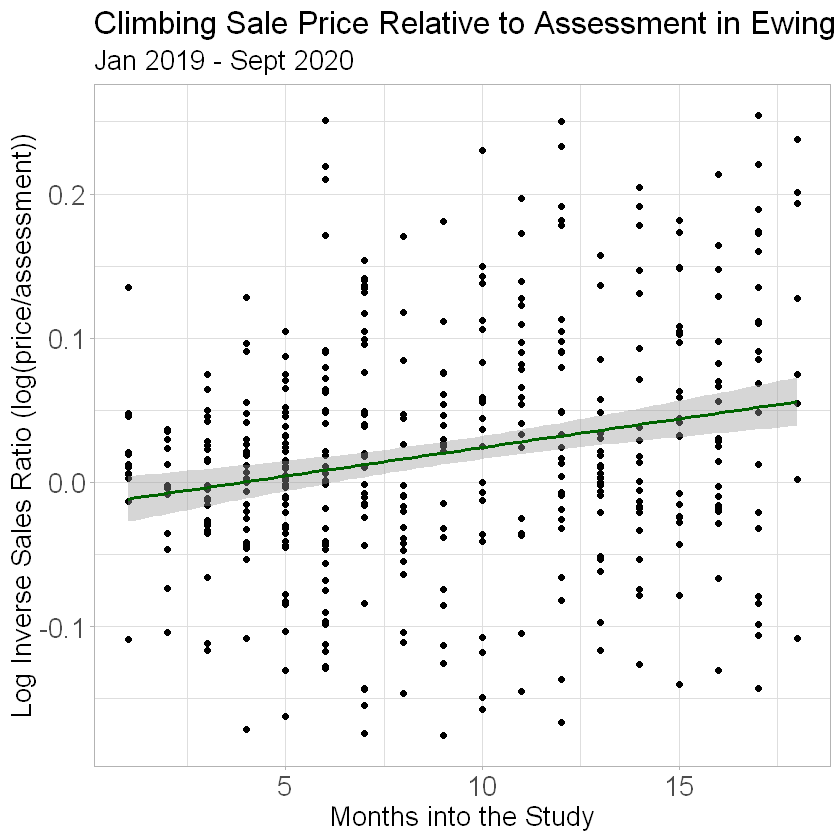

In [53]:
ggplot(data = inliers$data[[2]], mapping = aes(x = studyMonth, y = log(price / assmnt))) +
  geom_point() +
  theme_light() +
  labs(x = "Months into the Study",
       y = expression(paste(italic(ln), " ", 
                            bgroup("(",over(price,assessment), ")"))),
       title = "Climbing Sale Price Relative to Assessment in Ewing",
       subtitle = "Jan 2019 - Sept 2020") +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16)) +
  geom_smooth(method = 'lm', formula = y~x, color = "darkgreen")

This graph shows that prices increased more than 5 percent in Ewing over the course of the study period.

A trend line like this one is calculated for each group, and the slope of the line is recorded as "monthlyGrowth". 

## Checking Trend Significance

Some of this variation may be due to random chance, so I'll need to test the significance of each one.

I'll make a new column called "significant" and mark it TRUE only if the slope is steep enough that there is a better than 90% chance the trend is significant (p < 0.1). For trends marked "significant", I'll calculate the effect of that slope over 12 months as "annualGrowth". Otherwise, annual growth is marked zero.

Then annual growth is calculated with this equation:
$$Annual Growth = (1 + Monthly Growth)^{12} - 1$$

In [54]:
# Apply the market trend function to the outer data frame:
inliers <- inliers %>%
  mutate(marketTrend = map(data, market_trend_func),
           # return the slope of marketTrend:
         monthlyGrowth = sapply(marketTrend, function(x) x$coefficients[2]),
           # significant = TRUE at 90% conf level if p <= 0.1:
         significant = sapply(marketTrend, function(x) {
             (summary(x)$coefficients[2,4]) <= 0.1}),
           # If slope is significant, use Annual Market Condition Trend Equation. 
           # Else annualGrowth = 0
         annualGrowth = ifelse(significant == TRUE, (1 + monthlyGrowth)^12 - 1, 0))

## Price Adjustments

Now that we know how much sales ratios changed over the course of our study, we can calculate the price each property would have had if they had all been sold on the same day -- say, Jan 1 of the given year. 

I had filtered out all groups with fewer than 30 data points, but now I'll come back to the whole dataset, which contains both the small groups and the outliers. The outliers will be adjusted if they belong to a group with a significant trend. I'll join the monthly and yearly growth rates to their particular groups, and use them to create an adjusted sale price for every sale.

If there is no significant trend, the actual price is used as the adjusted price.

In [55]:
# Join inliers and propSales to include groups with N < 30:
propSales <- left_join(propSales, inliers[,c("nestIndex", "monthlyGrowth", "significant", "annualGrowth")], by = "nestIndex") 

propSales <- propSales %>%
  mutate(adjPrice = if_else(significant, 
                             # adjPrice = Price * [(1 + monthlyGrowth)^adj_months],
                             # where adj_months = months until assessment date
                             # (negative, in this case, to Jan 1 of the given year)
                               price * (1 + monthlyGrowth)^((-1)*(month(date) - 1)),
                              price,
                              missing = price))


## Final Sales Ratios

Now I can calculate final sales ratios, using the adjusted prices.

In [56]:
propSales <- propSales %>%
  mutate(adjSR = assmnt / adjPrice)

These statistics are now ready to be used in further studies. Let's summarize the ratios and see how they look.

In [61]:
propSales <- propSales %>%
  mutate(twp = sapply(twp, function (x)
      switch(EXPR = as.character(x), 
                      "1101" = "East Windsor", "1102" = "Ewing",
                      "1103" = "Hamilton", "1104" = "Hightstown",
                      "1105" = "Hopewell Bor", "1106" = "Hopewell Twp",
                      "1107" = "Lawrence", "1108" = "Pennington",
                      "1111" = "Trenton", "1112" = "Robbinsville",
                      "1113" = "West Windsor")))


Princeton is not represented. I assume there were actually sales in Princeton in 2019 and 2020, but they didn't make it into the publicly available property data.

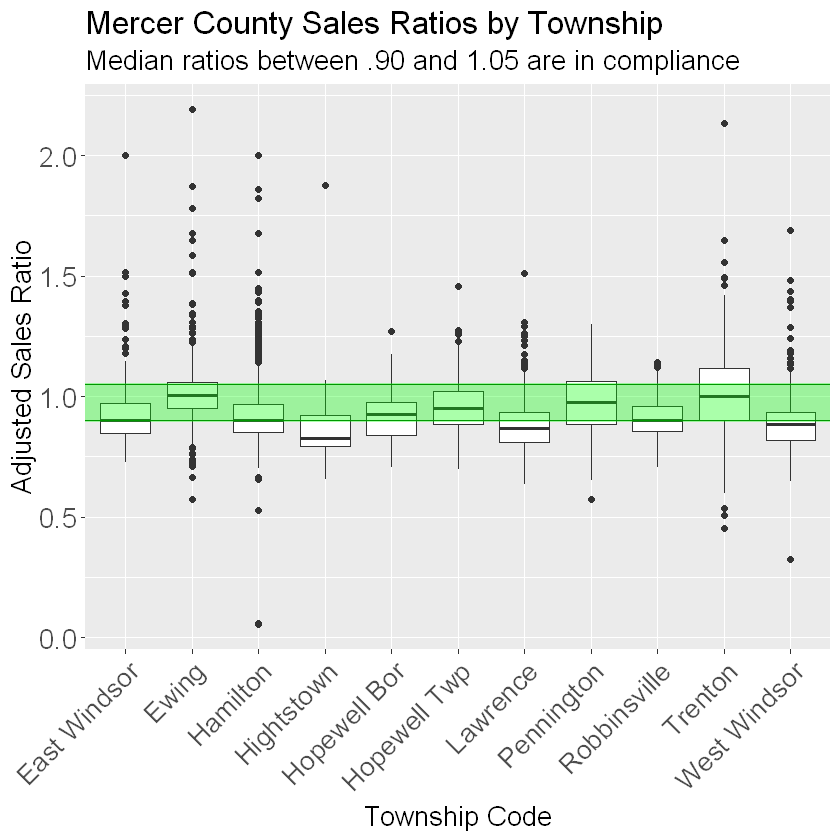

In [62]:
ggplot(propSales, aes(x=factor(twp), y=adjSR)) +
  geom_boxplot() +
  ggtitle("Mercer County Sales Ratios by Township", "Median ratios between .90 and 1.05 are in compliance")+
  xlab("Township Code")+
  ylab("Adjusted Sales Ratio")+
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16))+
  theme(axis.text.x = element_text(hjust = 1, vjust = 1, angle=45)) +
  geom_hline(aes(yintercept=0.90), color="darkgreen")+
  geom_hline(aes(yintercept=1.05), color="darkgreen")+
  geom_hline(aes(yintercept=.975), color="green", 
             size=11, alpha = 1/3)

In Minnesota, a median sales ratio between 90% and 105% is considered in compliance. That range is represented by the green band in the figure above, while the black line in the middle of each box is that township's median sales ratio. East Windsor squeaks by with exactly 90%. Hightstown, Lawrence, and West Windsor are just under the line, but the others look good, and Ewing and Trenton are just about perfect!

How does Mercer County compare to some other counties?

## Lowest Median Ratios:
Union County has a median sales ratio of 0.357

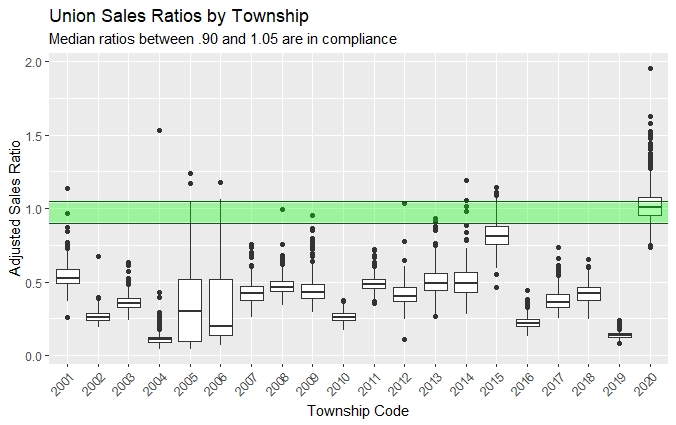

Middlesex county has a median sales ratio of 0.43

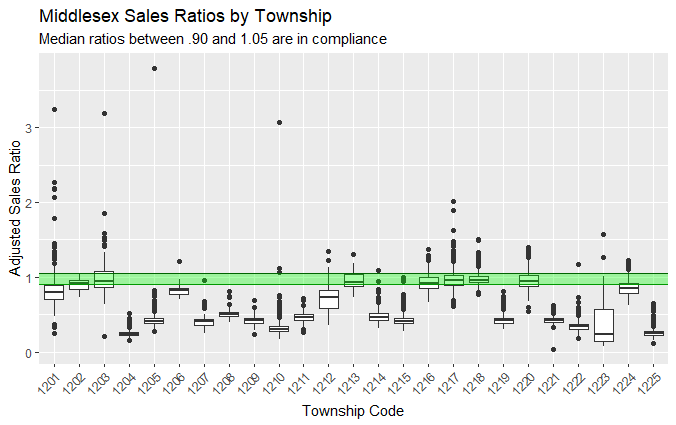

## Highest Median Ratios:

Salem County has a median sales ratio of 1.01.

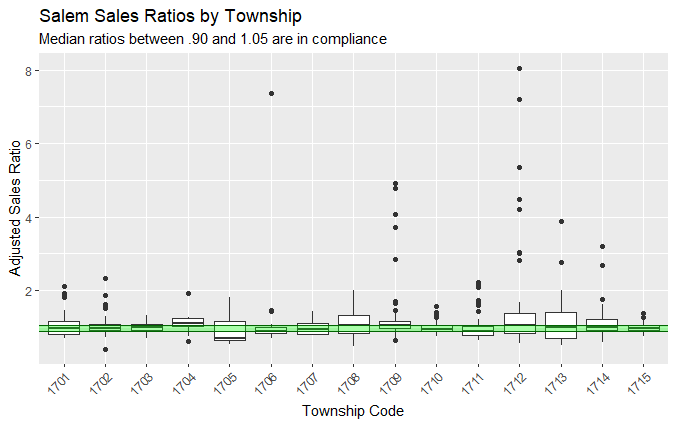

Cumberland County has a median sales ratio of 0.945.

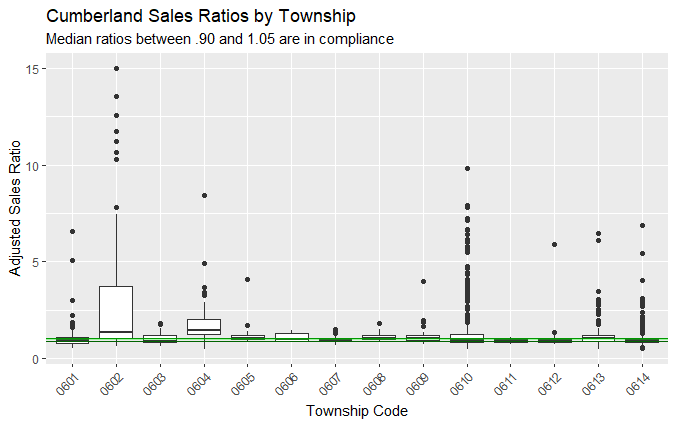

## Calculating Price-Related Bias

Sales ratios are sometimes biased in different ways depending on the value of the property. Expensive properties may be chronically under-assessed or over-assessed compared to less expensive ones. The price-related bias (PRB) measures the change in sales ratio as the value of a property increases.

Here I will once again filter the outliers and join similar properties back together by their nested index. For each group, I calculate the median sales ratio and then the price-related bias.

In [24]:
# Define the linear regression function
PRB_func <- function(df){
    lm(pctChange ~ wtdPropertyValue, data = df)
}

#Transform the x and y variables in advance
inliers <- propSales %>% 
  filter(outlier == FALSE) %>%
  group_by(nestIndex) %>%
  nest() %>%
  mutate(median = sapply(data, function(x) median(x$adjSR))) %>%
  unnest(cols = data) %>%
  mutate(pctChange = (adjSR - median)/median,
        wtdPropertyValue = log((assmnt/median)/2 + adjPrice/2)/log(2))

#Group, apply the regression function, and return the slope
inliers <- inliers %>% 
  group_by(nestIndex, twp) %>%
  nest() %>%
  mutate(PRB = map(data, PRB_func),
        PRB = sapply(PRB, function(x) x$coefficients[2])) %>%
  na.omit() %>%
  unnest(cols = data) %>%
  dplyr::select(nestIndex, twp, class, PRB) %>%
  unique() 

The bare bones of this calculation are a linear regression of the sales ratio (y) onto the property value (x).

$$Sales Ratio = \beta_{0} + \beta_{1} Property Value + \epsilon $$

The sales ratio is altered to represent a percent change from the median, and the property value, calculated as the average of the sale price and the assessment, is also altered to represent a percent change.

$$\frac{(Sales Ratio - Median Sales Ratio)}{Median Sales Ratio} = \beta_{0} + \beta_{1} \frac{LN(\frac{Assessment}{Median})/2 + Sale Price/2}{LN(2)} + \epsilon$$

The slope of the result can be interpreted as the expected change in ratios as property values double. If ratios increase as property values increase, the resulting PRB will be positive. So let's see what we've got:

In [25]:
inliers

nestIndex,twp,class,PRB
<int>,<chr>,<dbl>,<dbl>
1,East Windsor,2,-0.025854887
2,East Windsor,4,0.085962340
4,Ewing,2,-0.022152098
5,Ewing,4,0.047049047
6,Ewing,1,-0.137340725
7,Hamilton,2,-0.005992569
8,Hamilton,1,-0.280859768
9,Hamilton,4,-0.020674771
10,Hightstown,2,-0.046705331


Each dot in the chart below represents price-related bias (PRB) for one property class in one township. Townships don't always have sales in every property class. The dots on the left side of the reference line have a negative PRB, and the magnitude represents the percent decrease in sales ratios as property values double. For these points, more expensive properties tend to be undervalued.
On the right side are the property classes for each township with positive PRB. The distance from the reference line is the percent increase in sales ratios as property values double. For these points, more expensive properties tend to be overvalued.

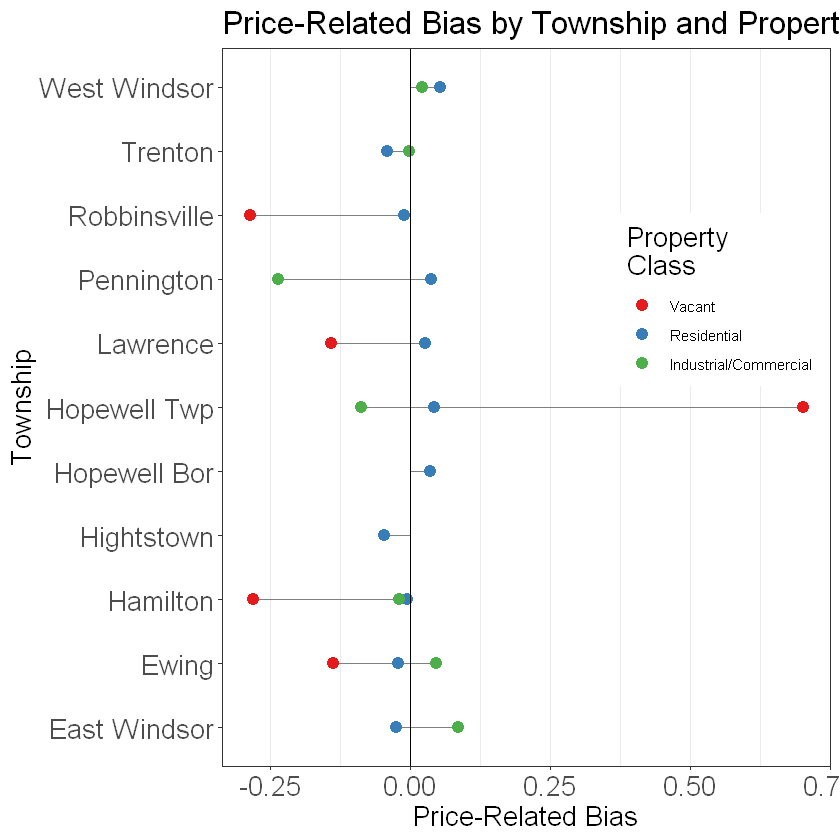

In [26]:
ggplot(inliers, aes(y=twp, x=PRB)) +
  theme_bw() +
  labs(title = "Price-Related Bias by Township and Property Class",
      x = "Price-Related Bias",
      y = "Township",
      colour = "Property\nClass") +
  geom_segment(aes(yend = twp), xend = 0, colour = "grey50") +
  geom_point(size = 3, aes(colour = factor(class))) +
  scale_color_discrete(labels = c("Vacant", "Residential", "Industrial/Commercial"), 
                       type = RColorBrewer::brewer.pal(3, "Set1"))+
    theme(
         title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16),
         panel.grid.major.y = element_blank(),   # No horizontal grid lines
         legend.position = c(1, 0.65),           # Put legend inside plot area
         legend.justification = c(1, 0.5) 
    ) +
  geom_vline(xintercept = 0)

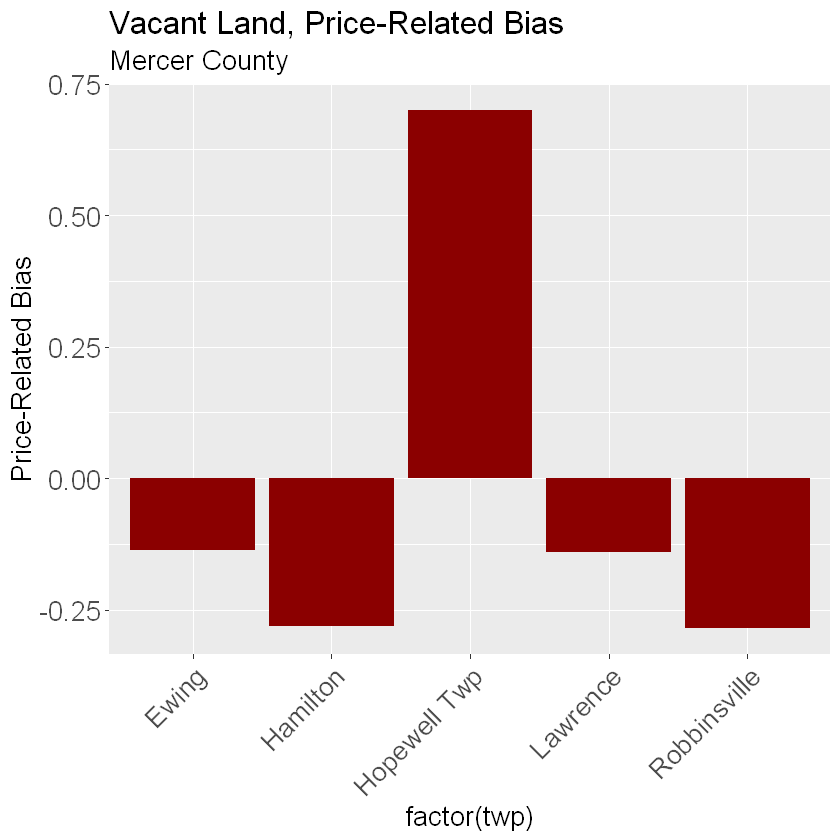

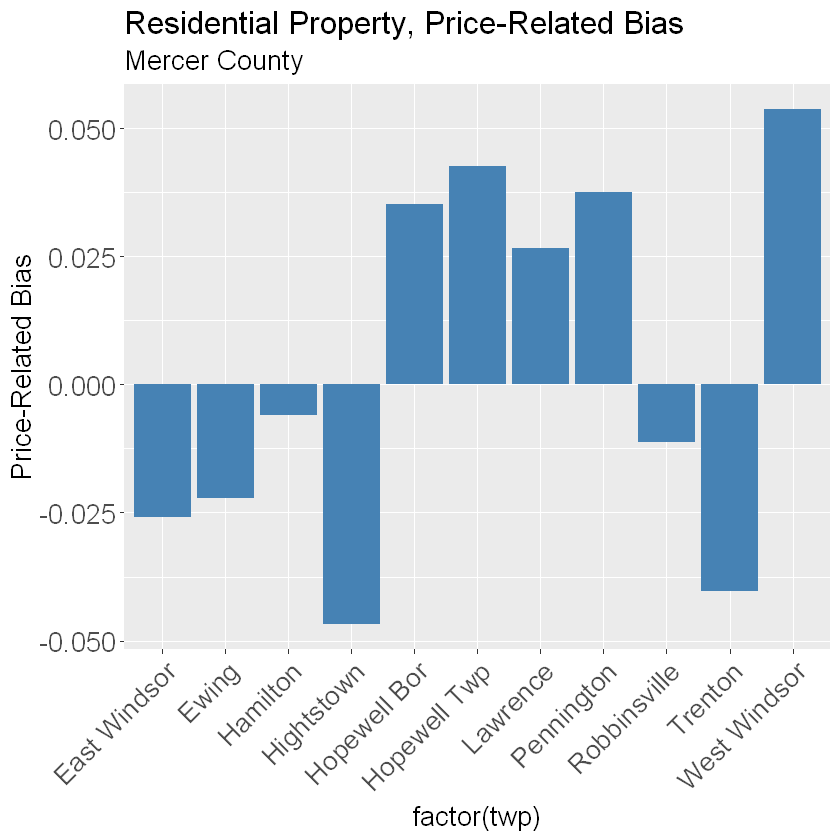

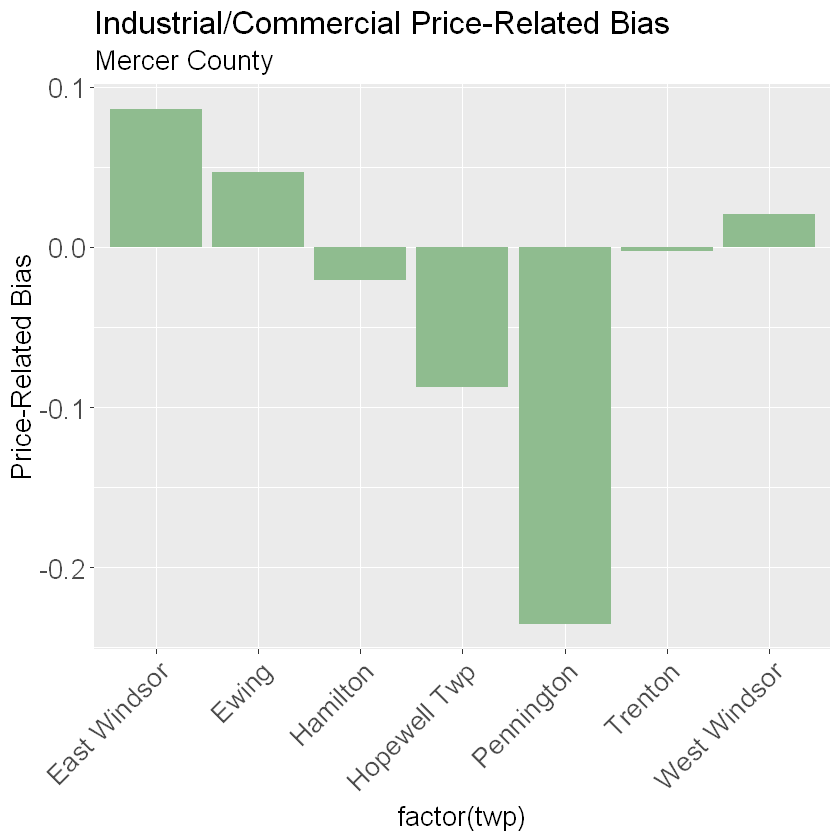

In [27]:
ggplot(inliers %>% filter(class == 1), aes(x=factor(twp), y=PRB)) +
  geom_col(position="dodge", fill = "darkred") +
  ggtitle("Vacant Land, Price-Related Bias", "Mercer County")+
  ylab("Township") +
  ylab("Price-Related Bias") +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16),
        axis.text.x = element_text(hjust = 1, vjust = 1, angle=45))

ggplot(inliers %>% filter(class == 2), aes(x=factor(twp), y=PRB)) +
  geom_col(position="dodge", fill = "steelblue") +
  ggtitle("Residential Property, Price-Related Bias", "Mercer County")+
  ylab("Township")+
  ylab("Price-Related Bias") +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16),
        axis.text.x = element_text(hjust = 1, vjust = 1, angle=45))
       
ggplot(inliers %>% filter(class == 4), aes(x=factor(twp), y=PRB)) +
  geom_col(position="dodge", fill="darkseagreen") +
  ggtitle("Industrial/Commercial Price-Related Bias", "Mercer County")+
  ylab("Township")+
  ylab("Price-Related Bias") +
  theme(title = element_text(size=16), axis.title = element_text(size=16), axis.text = element_text(size=16),
        axis.text.x = element_text(hjust = 1, vjust = 1, angle=45))

When residential property values double in East Windsor, sales ratios decrease by 2.5%
In Hightstown, doubling property values decreases the sales ratio by 4.6%
